<a href="https://colab.research.google.com/github/Physsionist/deep_architecture/blob/main/model_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -r drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/requirements.txt -q

     |████████████████████████████████| 117 kB 4.2 MB/s 
     |████████████████████████████████| 948 kB 29.5 MB/s 


In [4]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import matplotlib.pyplot as plt
import time
import copy


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight


import cv2
import albumentations as A

from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import models, transforms

from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device(0)



# Setup / Exploration

In [5]:
base_path = "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/"

In [6]:
df = pd.read_csv(base_path+'styles_filepath.csv')
print(df.shape)
df.head()

(10113, 5)


,class_index,class_label,filepath,height,width
0,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,681,968
1,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,534,800
2,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,668,1000
3,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,663,1000
4,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,600,800


#### Source Data
https://www.kaggle.com/datasets/dumitrux/architectural-styles-dataset

In [ ]:
# copy preprocessed images
! cp "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/archive_new_6.27_256x256.zip" archive_new.zip

# extract and delete
!unzip -q archive_new.zip

!rm archive_new.zip -r

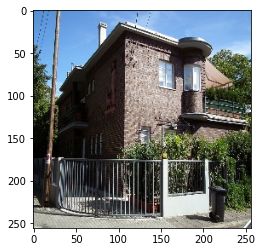

In [ ]:
# pull up an image
row = df.iloc[10]
image_path = row['filepath']

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

# View Architectural Styles

In [ ]:
# just pick one example from each class
demo_df = df.groupby('class_index').last().reset_index()
demo_df.head(2)

,class_index,class_label,filepath,height,width
0,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,1000,750
1,1,Queen Anne architecture,archive/architectural-styles-dataset/Queen Ann...,600,650


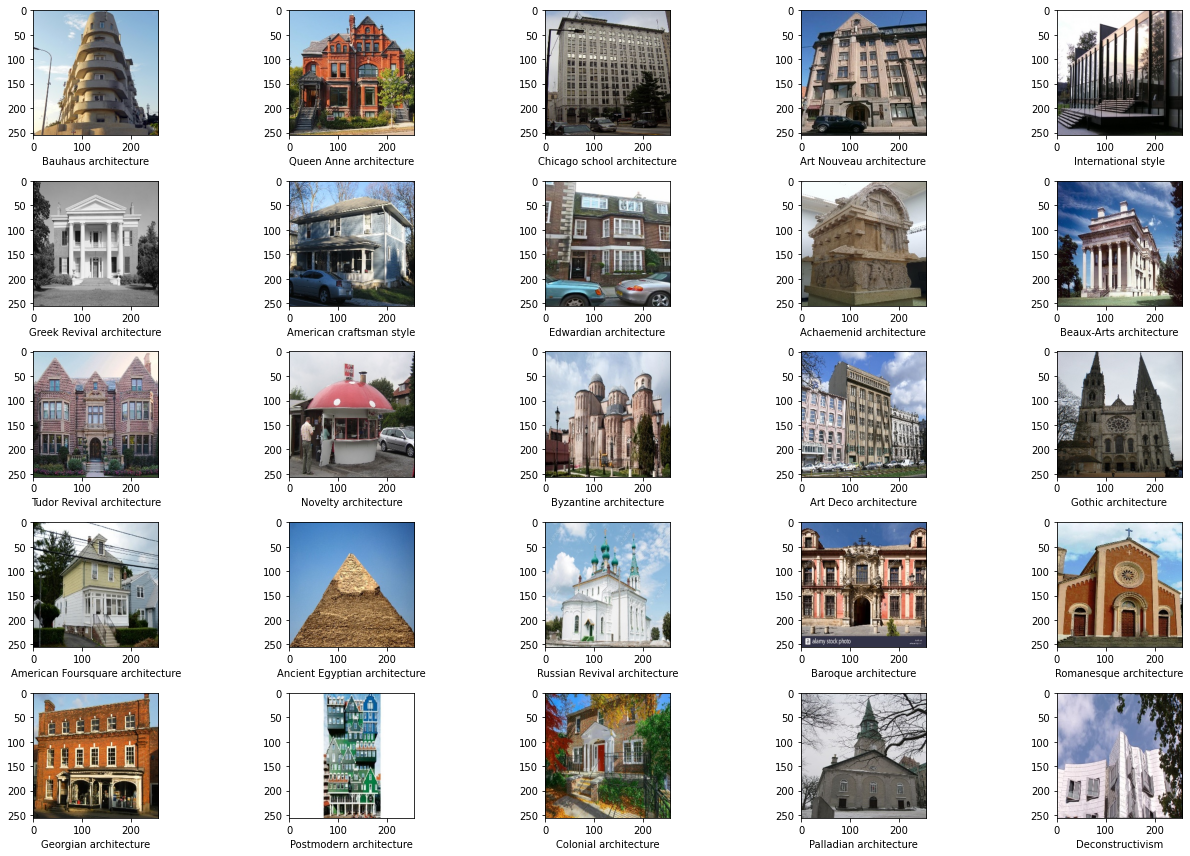

In [ ]:
xdim=5
ydim=5

figure, axis = plt.subplots(ydim, xdim, figsize =(18, 12))
for i in range(ydim):
    for j in range(xdim):
        row = demo_df.iloc[xdim*i+j, 1:3]
        img = cv2.imread(row[1])
        axis[i][j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
        axis[i][j].set_xlabel(row[0])

plt.tight_layout()
plt.show()

### Note Imbalanced Classes

In [ ]:
temp = df.groupby('class_label').size().reset_index().rename({0:'N'}, axis=1)
temp['Proportion'] = (temp['N'] / len(df)).round(3)
temp

,class_label,N,Proportion
0,Achaemenid architecture,392,0.039
1,American Foursquare architecture,362,0.036
2,American craftsman style,364,0.036
3,Ancient Egyptian architecture,406,0.040
4,Art Deco architecture,566,0.056
5,Art Nouveau architecture,615,0.061
6,Baroque architecture,456,0.045
7,Bauhaus architecture,315,0.031
8,Beaux-Arts architecture,424,0.042
9,Byzantine architecture,313,0.031


## Dataset

In [ ]:
class ArchStyleAugment(Dataset):
    def __init__(self, df, augment=False):
        self.df = df

        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
 
                # pixel-level transformation
                # A.RandomBrightnessContrast(p=1),
                A.GaussNoise(p=1),
                
                # we will normalize according to ImageNet since we will be using a pre-trained resnet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                A.CenterCrop(width=224, height=224),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
    

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['filepath']
        
        # read the img
        img = cv2.imread(path)

        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Transform
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(row['class_index'])
        
        return img, label

### Make sure Dataset works

In [ ]:
augment_iter_true = iter(ArchStyleAugment(df, augment=True))
augment_iter_false = iter(ArchStyleAugment(df, augment=False))

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

### Vertical Flip

        augmented             original


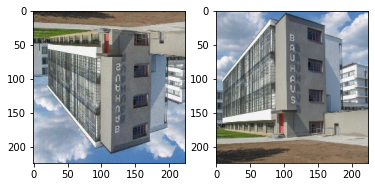

In [ ]:
img1, label1 = next(augment_iter_true)
img1 = np.transpose(np.array(img1), (1,2,0))
for i in range(3):
    img1[:,:,i] = (img1[:,:,i] * std[i]) + mean[i]

img2, label2 = next(augment_iter_false)
img2 = np.transpose(np.array(img2), (1,2,0))
for i in range(3):
    img2[:,:,i] = (img2[:,:,i] * std[i]) + mean[i]

print('        augmented             original')

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1);
ax[1].imshow(img2);

### Horizontal Flip

        augmented             original


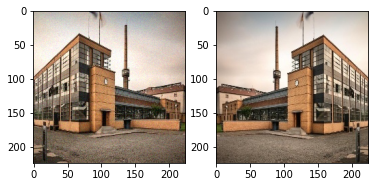

In [ ]:
img1, label1 = next(augment_iter_true)
img1 = np.transpose(np.array(img1), (1,2,0))
for i in range(3):
    img1[:,:,i] = (img1[:,:,i] * std[i]) + mean[i]

img2, label2 = next(augment_iter_false)
img2 = np.transpose(np.array(img2), (1,2,0))
for i in range(3):
    img2[:,:,i] = (img2[:,:,i] * std[i]) + mean[i]

print('        augmented             original')

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1);
ax[1].imshow(img2);

# Training Functions

In [ ]:
def one_pass(model, dataloader, optimizer, scheduler, lossFun, backprop):
    
    if backprop == True:
        model.train()
    else:
        model.eval()

    y_true = []
    y_pred = []    
    total_loss = 0
    obs_count = 0

    for x, y in tqdm(dataloader):
        y_hat = model(x)
        loss = lossFun(y_hat, y.type(torch.LongTensor))

        y_hat = torch.argmax(y_hat, dim=1)

        y_true.append(y)
        y_pred.append(y_hat)

        total_loss += loss.item()
        obs_count += len(y)

        if backprop == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        

    avg_loss = total_loss / obs_count

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    return (avg_loss, accuracy, balanced_accuracy)


def train_loop(epochs, train_dl_var, valid_dl_var, model_var, optimizer_var, loss_var, scheduler_var, file_name, gdrive_save):
    best_loss = 100
    metrics = []
    for epoch in tqdm(range(1, epochs+1)):
        start_time = time.time()
        train_loss = one_pass(model, train_dl_var, optimizer_var, scheduler_var, loss_var, backprop=True)
        valid_loss = one_pass(model, valid_dl_var, optimizer_var, scheduler_var, loss_var, backprop=False)
        end_time = time.time()
        elapsed = (end_time - start_time) / 60

        if valid_loss[0] < best_loss:
            save_model_weights(file_name, gdrive_save)
            best_loss = valid_loss[0]

        print('epoch:', str(epoch).rjust(2, '0'), \
              ' train_loss:'   , str(round(train_loss[0], 5)).ljust(7, '0'), \
              ' train_acc:'    , str(round(train_loss[1], 5)).ljust(7, '0'), \
              ' train_balacc:' , str(round(train_loss[2], 5)).ljust(7, '0'), \

              ' valid_loss:'   , str(round(valid_loss[0], 5)).ljust(7, '0'), \
              ' valid_acc:'    , str(round(valid_loss[1], 5)).ljust(7, '0'), \
              ' valid_balacc:' , str(round(valid_loss[2], 5)).ljust(7, '0'), \

              ' mins:', str(round(elapsed, 3)).ljust(5, '0'))

    return None

def save_model_weights(output_model_file, gdrive_save=False):
    # assumes model=model, optimizer=optimizer
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict()}

    if gdrive_save:
        output_model_file = base_path + output_model_file
        torch.save(checkpoint, output_model_file)
    else:
        torch.save(checkpoint, output_model_file)

# Select 5 Favorite Classes (full 25 didn't perform well)

In [7]:
top5_favs = ['Gothic architecture', 'Byzantine architecture', 'Greek Revival architecture', \
             'Russian Revival architecture', 'Art Deco architecture']

In [11]:
re_index = {v: k for k, v in dict(enumerate(top5_favs)).items()}
re_index

{'Art Deco architecture': 4,
 'Byzantine architecture': 1,
 'Gothic architecture': 0,
 'Greek Revival architecture': 2,
 'Russian Revival architecture': 3}

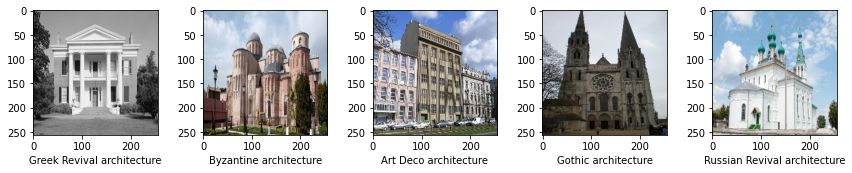

In [ ]:
figure, axis = plt.subplots(1, 5, figsize =(12, 8))
for i in range(5):
    row = demo_df[demo_df['class_label'].isin(top5_favs)].iloc[i, 1:3]
    img = cv2.imread(row[1])
    axis[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    axis[i].set_xlabel(row[0])

plt.tight_layout()
plt.show()

In [8]:
df_filt = df[df['class_label'].isin(top5_favs)]
df_filt.head(2)

,class_index,class_label,filepath,height,width
2345,5,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,480,640
2346,5,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,600,800


In [12]:
df_filt['class_index'] = df_filt['class_label'].map(re_index)
df_filt.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,class_index,class_label,filepath,height,width
2345,2,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,480,640
2346,2,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,600,800


#### Class Imbalance

In [15]:
temp = df_filt.groupby(['class_index', 'class_label']).size().reset_index().rename({0:'N'}, axis=1)
temp['Proportion'] = (temp['N'] / len(df_filt)).round(3)
temp

,class_index,class_label,N,Proportion
0,0,Gothic architecture,331,0.159
1,1,Byzantine architecture,313,0.150
2,2,Greek Revival architecture,523,0.251
3,3,Russian Revival architecture,352,0.169
4,4,Art Deco architecture,566,0.271


## Train/Test Split

In [ ]:
df_train, df_valid = train_test_split(df_filt, test_size=0.2, random_state=0)

## Fix Class Imblance by changing the loss function

In [ ]:
y = df_train.class_index.values
class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights)

tensor([1.2831, 1.2880, 0.8039, 1.1788, 0.7397])


## Use Rate Scheduler

https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


# Resnet - Partially Frozen

### Setup

In [ ]:
resnet = models.resnet18(pretrained=True)

# turn off gradients for all the parameters
for param in resnet.parameters():
    param.requires_grad = False

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 5)
print(resnet.fc)

# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)


# pass the appropriate parameters to the optimizer
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
# print(params_to_update)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=5, bias=True)
True
True


## Train

In [ ]:
batch_size = 32

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = resnet
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_resnet_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.02525  train_acc: 0.71403  train_balacc: 0.70410  valid_loss: 0.01610  valid_acc: 0.82734  valid_balacc: 0.82111  mins: 2.667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.01851  train_acc: 0.79916  train_balacc: 0.79069  valid_loss: 0.01665  valid_acc: 0.79856  valid_balacc: 0.78596  mins: 2.685


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 03  train_loss: 0.01793  train_acc: 0.79017  train_balacc: 0.78182  valid_loss: 0.01617  valid_acc: 0.82254  valid_balacc: 0.80896  mins: 2.686


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 04  train_loss: 0.01736  train_acc: 0.79736  train_balacc: 0.79011  valid_loss: 0.01557  valid_acc: 0.82734  valid_balacc: 0.81175  mins: 2.653


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 05  train_loss: 0.01659  train_acc: 0.82134  train_balacc: 0.81742  valid_loss: 0.01701  valid_acc: 0.81055  valid_balacc: 0.80099  mins: 2.679


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 06  train_loss: 0.01653  train_acc: 0.81954  train_balacc: 0.81264  valid_loss: 0.01636  valid_acc: 0.82014  valid_balacc: 0.80638  mins: 2.688


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 07  train_loss: 0.01485  train_acc: 0.83153  train_balacc: 0.82830  valid_loss: 0.01606  valid_acc: 0.83453  valid_balacc: 0.81886  mins: 2.665


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 08  train_loss: 0.01553  train_acc: 0.83993  train_balacc: 0.83382  valid_loss: 0.01569  valid_acc: 0.82734  valid_balacc: 0.81249  mins: 2.682


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 09  train_loss: 0.01553  train_acc: 0.82914  train_balacc: 0.81721  valid_loss: 0.01654  valid_acc: 0.82494  valid_balacc: 0.80616  mins: 2.636


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 10  train_loss: 0.01481  train_acc: 0.83933  train_balacc: 0.83291  valid_loss: 0.01651  valid_acc: 0.82494  valid_balacc: 0.80983  mins: 2.653


In [ ]:
df1

,epoch,train_loss,train_acc,train_balacc,valid_loss,valid_acc,valid_balacc,mins
0,1,0.02525,0.71403,0.70410,0.01610,0.82734,0.82111,2.667
1,2,0.01851,0.79916,0.79069,0.01665,0.79856,0.78596,2.685
2,3,0.01793,0.79017,0.78182,0.01617,0.82254,0.80896,2.686
3,4,0.01736,0.79736,0.79011,0.01557,0.82734,0.81175,2.653
4,5,0.01659,0.82134,0.81742,0.01701,0.81055,0.80099,2.679
5,6,0.01653,0.81954,0.81264,0.01636,0.82014,0.80638,2.688
6,7,0.01485,0.83153,0.82830,0.01606,0.83453,0.81886,2.665
7,8,0.01553,0.83993,0.83382,0.01569,0.82734,0.81249,2.682
8,9,0.01553,0.82914,0.81721,0.01654,0.82494,0.80616,2.636
9,10,0.01481,0.83933,0.83291,0.01651,0.82494,0.80983,2.653


# Resnet - Finetune

### Setup

In [ ]:
resnet = models.resnet18(pretrained=True)

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 5)
print(resnet.fc)


# pass the appropriate parameters to the optimizer
params_to_update = []
for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(len(params_to_update))

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=5, bias=True)
62


## Train

In [ ]:
batch_size = 32

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = resnet
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_resnet_finetune_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.03673  train_acc: 0.71523  train_balacc: 0.70366  valid_loss: 0.02731  valid_acc: 0.77458  valid_balacc: 0.75326  mins: 6.117


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.01396  train_acc: 0.84712  train_balacc: 0.84130  valid_loss: 0.01792  valid_acc: 0.83933  valid_balacc: 0.82492  mins: 6.006


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 03  train_loss: 0.01090  train_acc: 0.87950  train_balacc: 0.87347  valid_loss: 0.01515  valid_acc: 0.86811  valid_balacc: 0.85846  mins: 6.006


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 04  train_loss: 0.00939  train_acc: 0.90767  train_balacc: 0.90011  valid_loss: 0.01335  valid_acc: 0.87530  valid_balacc: 0.86236  mins: 6.024


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 05  train_loss: 0.00941  train_acc: 0.91487  train_balacc: 0.90834  valid_loss: 0.01740  valid_acc: 0.86091  valid_balacc: 0.84709  mins: 5.997


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 06  train_loss: 0.00987  train_acc: 0.89448  train_balacc: 0.88999  valid_loss: 0.01352  valid_acc: 0.86091  valid_balacc: 0.84242  mins: 6.017


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 07  train_loss: 0.00758  train_acc: 0.92026  train_balacc: 0.91505  valid_loss: 0.01331  valid_acc: 0.87050  valid_balacc: 0.85437  mins: 5.934


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 08  train_loss: 0.00768  train_acc: 0.91906  train_balacc: 0.91576  valid_loss: 0.01416  valid_acc: 0.86331  valid_balacc: 0.84603  mins: 5.927


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 09  train_loss: 0.00560  train_acc: 0.94125  train_balacc: 0.93698  valid_loss: 0.01351  valid_acc: 0.86571  valid_balacc: 0.85425  mins: 5.904


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 10  train_loss: 0.00513  train_acc: 0.94844  train_balacc: 0.94646  valid_loss: 0.01421  valid_acc: 0.87530  valid_balacc: 0.85599  mins: 5.910


In [ ]:
df2

,epoch,train_loss,train_acc,train_balacc,valid_loss,valid_acc,valid_balacc,mins
0,1,0.03673,0.71523,0.70366,0.02731,0.77458,0.75326,6.117
1,2,0.01396,0.84712,0.84130,0.01792,0.83933,0.82492,6.006
2,3,0.01090,0.87950,0.87347,0.01515,0.86811,0.85846,6.006
3,4,0.00939,0.90767,0.90011,0.01335,0.87530,0.86236,6.024
4,5,0.00941,0.91487,0.90834,0.01740,0.86091,0.84709,5.997
5,6,0.00987,0.89448,0.88999,0.01352,0.86091,0.84242,6.017
6,7,0.00758,0.92026,0.91505,0.01331,0.87050,0.85437,5.934
7,8,0.00768,0.91906,0.91576,0.01416,0.86331,0.84603,5.927
8,9,0.00560,0.94125,0.93698,0.01351,0.86571,0.85425,5.904
9,10,0.00513,0.94844,0.94646,0.01421,0.87530,0.85599,5.910


## Compare Performance
Fine Tuned has better metrics

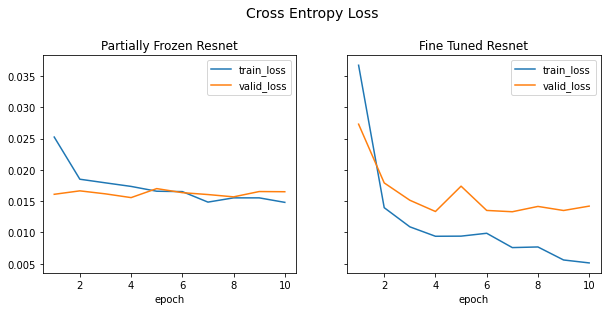

In [ ]:
fig, ax = plt.subplots(1, 2, figsize =(10, 4),  sharex=True, sharey=True)
df1.plot(x='epoch', y=['train_loss', 'valid_loss'], ax=ax[0], title='Partially Frozen Resnet');
df2.plot(x='epoch', y=['train_loss', 'valid_loss'], ax=ax[1], title='Fine Tuned Resnet');

fig.suptitle('Cross Entropy Loss', fontsize=14, y=1.05)
plt.show()

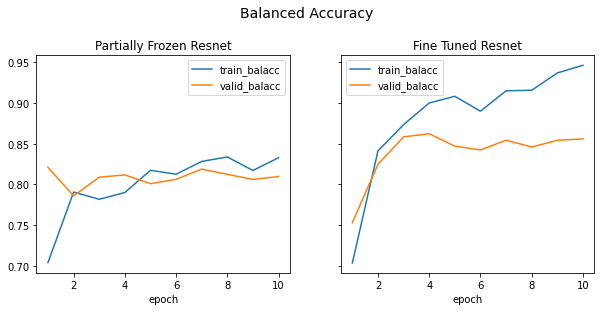

In [ ]:
fig, ax = plt.subplots(1, 2, figsize =(10, 4),  sharex=True, sharey=True)
df1.plot(x='epoch', y=['train_balacc', 'valid_balacc'], ax=ax[0], title='Partially Frozen Resnet');
df2.plot(x='epoch', y=['train_balacc', 'valid_balacc'], ax=ax[1], title='Fine Tuned Resnet');

fig.suptitle('Balanced Accuracy', fontsize=14, y=1.05)
plt.show()